<a href="https://colab.research.google.com/github/alirezash97/BRATS2015/blob/master/results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras import backend as K


def dice_coefficient(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient_loss(y_true, y_pred):
    return 1-dice_coefficient(y_true, y_pred)

In [0]:

# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('/content/drive/My Drive/BRATS2020/Model.01-0.95.h5', custom_objects={'dice_coefficient_loss':dice_coefficient_loss})
# summarize model.
model.summary()
# load dataset

In [0]:

import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt


img = nib.load('/content/drive/My Drive/BRATS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_t1.nii.gz').get_fdata()
y_true = nib.load("/content/drive/My Drive/BRATS2020/MICCAI_BraTS2020_TrainingData/BraTS20_Training_003/BraTS20_Training_003_seg.nii.gz").get_fdata()

In [40]:
print(img.shape)

(240, 240, 155)


In [41]:
print(y_true.shape)

(240, 240, 155)


In [0]:
y_true = y_true.reshape((1, 240, 240, 155)) 
y_true_ = np.zeros((48, 240, 240, 3))
for i in range (1, 49):
  tempp[i-1, :, :, :] = y_true[:, :, :, i*3:(i+1)*3]
y_true_ = tempp.reshape((48, 240, 240, 3))

In [0]:

img = img.reshape((1, 240, 240, 155))
tempp = np.zeros((48, 240, 240, 3))
for i in range (1, 49):
  tempp[i-1, :, :, :] = img[:, :, :, i*3:(i+1)*3]
image = tempp.reshape((1, 48, 240, 240, 3))

In [0]:
y_predict = model.predict(image)

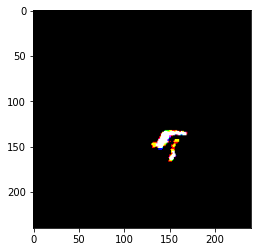

In [76]:
plt.imshow((y_true_[33, :, :, :] * 255).astype(np.uint8))

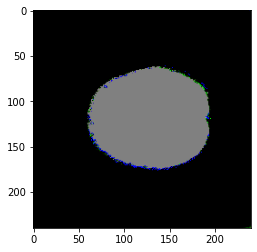

In [78]:
predict = y_predict.reshape((48, 240, 240, 3))
plt.imshow((predict[33, :, :, :] * 255).astype(np.uint8))


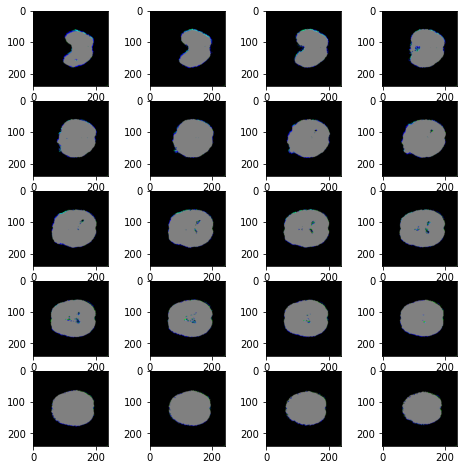

In [88]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = predict[i+15, :, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

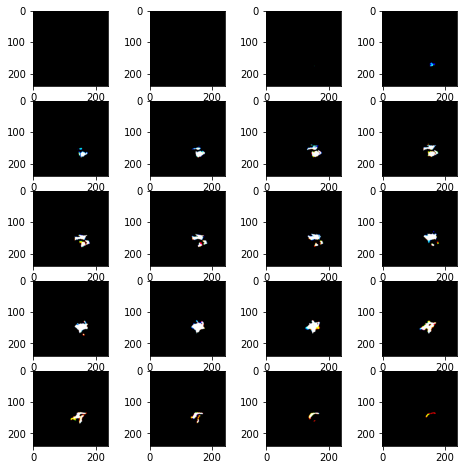

In [86]:
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = y_true_[i+15, :, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow((img * 255).astype(np.uint8))
plt.show()